In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os
from scipy import stats


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_svm'
should_savefig = True

In [3]:
results_files = os.listdir(data_dir)
df_res = pd.DataFrame()
for f in results_files:
    if 'csv' not in f:
        continue
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))
df_res = df_res[df_res['train_matthews'] > 0]

df_res.drop(columns=['Unnamed: 0'], inplace=True)
df_res.head(4)

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
3,0.001,NaN,0.088323,que,1.0,0.000000,rbf,0.000000,0.056676,0.200000,...,0.124849,0.355052,0.576686,0.568336,0.093402,0.000000,0.000000,0.060928,0.200000,0.500000
4,0.001,NaN,0.088323,que,10.0,0.000000,rbf,0.000000,0.056676,0.200000,...,0.126933,0.359907,0.546927,0.569174,0.093402,0.000000,0.000000,0.060928,0.200000,0.500000
9,0.010,NaN,0.393233,que,0.1,0.143858,rbf,0.150025,0.385656,0.435991,...,0.124845,0.355112,0.576158,0.568330,0.386206,0.114132,0.120805,0.365972,0.446461,0.560269
10,0.010,NaN,0.430299,que,1.0,0.138241,rbf,0.145259,0.361057,0.536037,...,0.124728,0.355087,0.575806,0.568265,0.423509,0.117322,0.124583,0.349646,0.541061,0.567854


In [4]:
df_best_rbf = df_res[df_res['kernel'] == 'rbf'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_lin = df_res[df_res['kernel'] == 'linear'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_sig = df_res[df_res['kernel'] == 'sigmoid'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)

In [5]:
df_best = df_res.sort_values(by=['matthews', 'train_matthews'], ascending=False).groupby('stock').head(1)

## Distributions

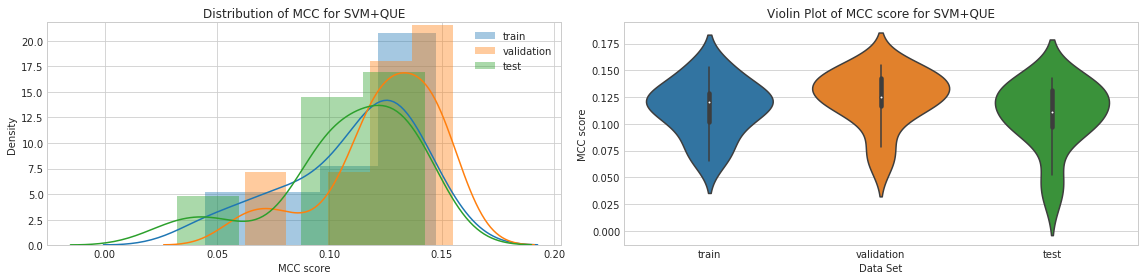

In [6]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.violinplot(data=df_best[['train_val_matthews', 'matthews', 'test_matthews', ]], ax=ax1)
plt.xticks([0,1,2], ['train', 'validation', 'test', ])
ax1.set_xlabel('Data Set')
ax1.set_ylabel('MCC score')
ax1.set_title('Violin Plot of MCC score for SVM+QUE')

sns.distplot(df_best[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best[['test_matthews']], label='test', ax=ax2)
ax2.set_title('Distribution of MCC for SVM+QUE')
ax2.set_xlabel('MCC score')
ax2.set_ylabel('Density')
ax2.legend()
plt.tight_layout()

if should_savefig:
    plt.savefig('que_svm_mcc_dist.png')

In [7]:
df_best.sort_values(by='test_matthews')[[
    'stock', 'kernel', 'test_matthews', 'matthews', 'train_matthews', 'train_val_matthews', 
    'C', 'gamma', 'coef0']]

,stock,kernel,test_matthews,matthews,train_matthews,train_val_matthews,C,gamma,coef0
189,4549,sigmoid,0.032304,0.124450,0.044635,0.119888,100.000,0.010,1.0
141,9062,sigmoid,0.052097,0.062361,0.063964,0.065219,1.000,0.100,1.0
23,9061,rbf,0.093155,0.103318,0.085900,0.073929,1.000,0.100,NaN
171,9058,sigmoid,0.094555,0.078425,0.077495,0.085181,10.000,0.001,1.0
23,11583,rbf,0.099416,0.113982,0.104075,0.098840,1.000,0.100,NaN
40,11869,rbf,0.101515,0.125429,0.126562,0.127730,100.000,100.000,NaN
63,12255,sigmoid,0.108394,0.146256,0.125885,0.116642,0.010,1.000,1.0
12,9761,rbf,0.111120,0.155044,0.126633,0.130294,0.010,100.000,NaN
218,4799,sigmoid,0.121606,0.129108,0.110880,0.109590,100.000,0.010,0.1
40,10470,sigmoid,0.126214,0.142101,0.129047,0.124448,0.001,1000.000,10.0


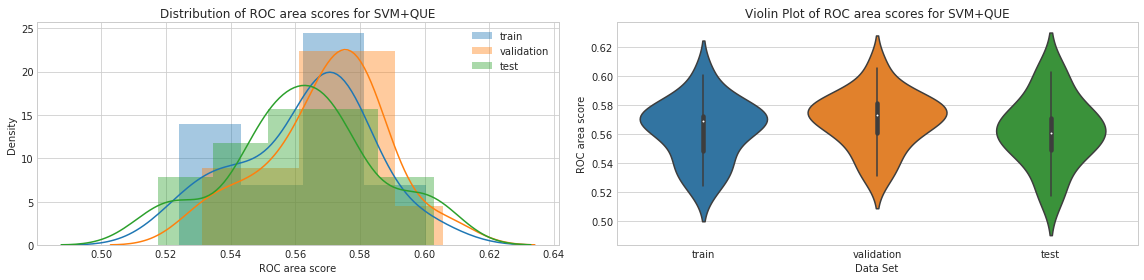

In [8]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.violinplot(data=df_best[['train_roc_auc', 'roc_auc', 'test_roc_auc', ]], ax=ax1)
plt.xticks([0,1,2], ['train', 'validation', 'test', ])
ax1.set_xlabel('Data Set')
ax1.set_ylabel('ROC area score')
ax1.set_title('Violin Plot of ROC area scores for SVM+QUE')

sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('Distribution of ROC area scores for SVM+QUE')
ax2.set_xlabel('ROC area score')
ax2.set_ylabel('Density')
ax2.legend()
plt.tight_layout()

if should_savefig:
    plt.savefig('que_svm_roc_auc_dist.png')

### Per kernel

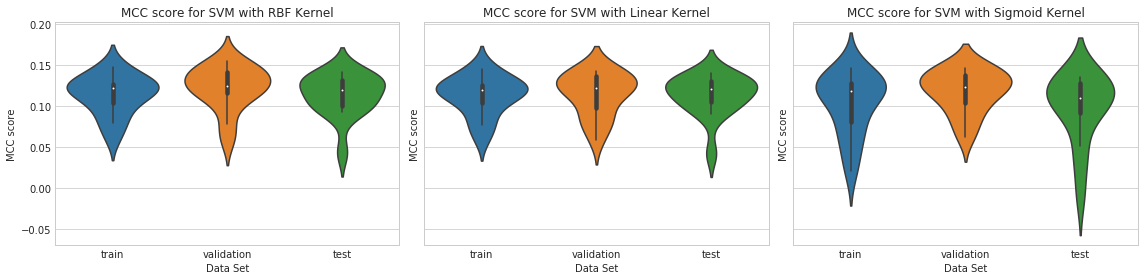

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.violinplot(data=df_best_rbf[['train_matthews', 'matthews', 'test_matthews',]], ax=ax1)
sns.violinplot(data=df_best_lin[['train_matthews', 'matthews', 'test_matthews',]], ax=ax2)
sns.violinplot(data=df_best_sig[['train_matthews', 'matthews', 'test_matthews',]], ax=ax3)
a = plt.setp([ax1, ax2, ax3], xticks=[0, 1, 2], xticklabels=['train', 'validation', 'test'], xlabel='Data Set',
            ylabel='MCC score')
ax1.set_title('MCC score for SVM with RBF Kernel')
ax2.set_title('MCC score for SVM with Linear Kernel')
ax3.set_title('MCC score for SVM with Sigmoid Kernel')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_mcc_per_kernel.png')

In [10]:
print(df_best_rbf[['train_matthews', 'matthews', 'test_matthews',]].describe().to_latex())
print(df_best_lin[['train_matthews', 'matthews', 'test_matthews',]].describe().to_latex())
print(df_best_sig[['train_matthews', 'matthews', 'test_matthews',]].describe().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 \\
mean  &        0.114469 &   0.122592 &       0.114096 \\
std   &        0.023811 &   0.026336 &       0.025391 \\
min   &        0.062020 &   0.058888 &       0.043992 \\
25\%   &        0.103975 &   0.115763 &       0.100465 \\
50\%   &        0.122878 &   0.125160 &       0.120548 \\
75\%   &        0.127751 &   0.141969 &       0.132248 \\
max   &        0.147411 &   0.155044 &       0.142386 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 \\
mean  &        0.113254 &   0.114916 &       0.113560 \\
std   &        0.023593 &   0.026026 &       0.024666 \\
min   &        0.061270 &   0.059446 &       0.042593 \\
25\%   &        0.104542 &   0.098334 &       0.105150 \\
50\%   &        0.119791 &   0.12248

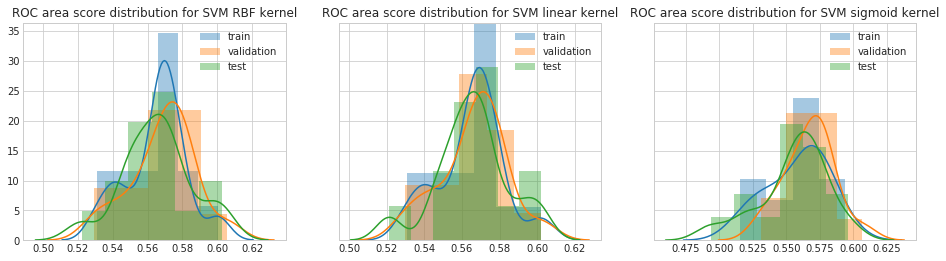

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.distplot(df_best_rbf[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best_lin[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('ROC area score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_roc_auc']], label='train', ax=ax3)
sns.distplot(df_best_sig[['roc_auc']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_roc_auc']], label='test', ax=ax3)
ax3.set_title('ROC area score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

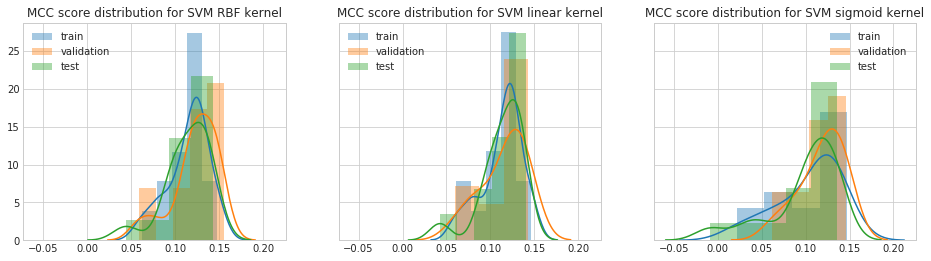

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)
sns.distplot(df_best_rbf[['train_matthews']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['matthews']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_matthews']], label='test', ax=ax1)
ax1.set_title('MCC score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best_lin[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_matthews']], label='test', ax=ax2)
ax2.set_title('MCC score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_matthews']], label='train', ax=ax3)
sns.distplot(df_best_sig[['matthews']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_matthews']], label='test', ax=ax3)
ax3.set_title('MCC score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

In [13]:
df_best_sig[['train_matthews', 'matthews', 'test_matthews']].describe()


,train_matthews,matthews,test_matthews
count,15.000000,15.000000,15.000000
mean,0.103312,0.118445,0.098153
std,0.036730,0.025635,0.041813
min,0.021764,0.062361,-0.008427
25%,0.080753,0.104647,0.091936
50%,0.118834,0.123657,0.110127
75%,0.128224,0.138583,0.128993
max,0.147290,0.146541,0.135263


## Compare with QUE+LOG

In [14]:
df_log = pd.read_csv('res_log_que.csv')
df_log.head()

,Unnamed: 0,class_weights,f1,kappa,kernel,matthews,precision,recall,roc_auc,stock,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,9269,"{0.0: 0.836091273297335, 1.0: 1.2438455558434827}",0.510800,0.093214,logistic,0.100470,0.435052,0.627165,0.550638,9269,...,0.094565,0.448586,0.555066,0.548218,0.507599,0.086723,0.089307,0.449844,0.582545,0.545330
1,3022,"{0.0: 0.7298160255435608, 1.0: 1.587826662256037}",0.440221,0.102841,logistic,0.113407,0.357526,0.581350,0.560990,3022,...,0.115502,0.368437,0.586173,0.562168,0.451454,0.099532,0.107777,0.366223,0.588595,0.557860
2,2051,"{0.0: 0.5945376850188889, 1.0: 3.144448083851949}",0.308374,0.096571,logistic,0.118968,0.213634,0.558961,0.579171,2051,...,0.122543,0.208199,0.593842,0.583414,0.304148,0.097964,0.123845,0.206687,0.575964,0.584607
3,3879,"{0.0: 0.7008834051252099, 1.0: 1.7445029983645...",0.428990,0.124127,logistic,0.137354,0.337460,0.591021,0.576551,3879,...,0.136157,0.350998,0.584954,0.575203,0.448760,0.126081,0.139540,0.354127,0.613801,0.576524
4,10166,"{0.0: 0.8430666549574076, 1.0: 1.2287213618328...",0.512189,0.119137,logistic,0.120872,0.470075,0.563449,0.561400,10166,...,0.108777,0.460605,0.563420,0.555355,0.504377,0.102871,0.104679,0.458109,0.561199,0.553257


In [15]:
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])
df_best.head()

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews_log,train_precision_log,train_recall_log,train_roc_auc_log,train_val_f1_log,train_val_kappa_log,train_val_matthews_log,train_val_precision_log,train_val_recall_log,train_val_roc_auc_log
0,0.010,NaN,0.427307,que,100.00,0.146800,rbf,0.155044,0.373604,0.521666,...,0.125276,0.355845,0.572359,0.568539,0.421187,0.118964,0.125167,0.351395,0.528212,0.568139
1,100.000,NaN,0.294126,que,1.00,0.111888,rbf,0.147542,0.194451,0.615188,...,0.146122,0.208106,0.611383,0.601755,0.319661,0.114920,0.151100,0.213468,0.639043,0.603678
2,0.010,1.0,0.420016,que,1.00,0.138216,sigmoid,0.146256,0.345570,0.537134,...,0.123718,0.336310,0.572098,0.568951,0.430402,0.111052,0.122741,0.338093,0.592867,0.568086
3,1000.000,NaN,0.263692,que,0.01,0.118773,rbf,0.144224,0.251364,0.439015,...,0.105855,0.184566,0.580131,0.575097,0.256466,0.082278,0.101212,0.177427,0.484862,0.569234
4,0.001,10.0,0.415425,que,1000.00,0.121182,sigmoid,0.142101,0.308560,0.638472,...,0.129243,0.310112,0.596408,0.574360,0.398935,0.112480,0.126299,0.305230,0.576342,0.572930


In [16]:
df_best['diff_train_matthews'] = df_best['train_matthews'] - df_best['train_matthews_log'] 
df_best['diff_matthews'] = df_best['matthews'] - df_best['matthews_log'] 
df_best['diff_test_matthews'] = df_best['test_matthews'] - df_best['test_matthews_log'] 
df_best['diff_train_roc_auc'] = df_best['train_roc_auc'] - df_best['train_roc_auc_log'] 
df_best['diff_roc_auc'] = df_best['roc_auc'] - df_best['roc_auc_log'] 
df_best['diff_test_roc_auc'] = df_best['test_roc_auc'] - df_best['test_roc_auc_log'] 

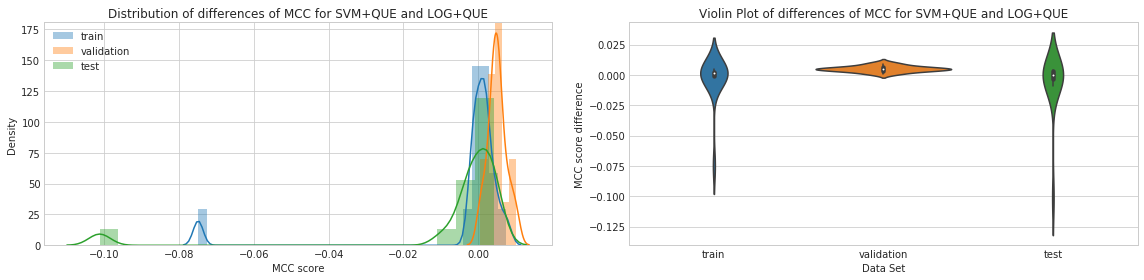

In [17]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.violinplot(data=df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', ]], ax=ax1)
plt.xticks([0,1,2], ['train', 'validation', 'test', ])
ax1.set_xlabel('Data Set')
ax1.set_ylabel('MCC score difference')
ax1.set_title('Violin Plot of differences of MCC for SVM+QUE and LOG+QUE')

sns.distplot(df_best[['diff_train_matthews']], label='train', ax=ax2)
sns.distplot(df_best[['diff_matthews']], label='validation', ax=ax2)
sns.distplot(df_best[['diff_test_matthews']], label='test', ax=ax2)
ax2.set_title('Distribution of differences of MCC for SVM+QUE and LOG+QUE')
ax2.set_xlabel('MCC score')
ax2.set_ylabel('Density')
ax2.legend()
plt.tight_layout()

if should_savefig:
    plt.savefig('que_svm_mcc_diff_dist.png')

In [18]:
print(df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &            -0.003569 &       0.005076 &           -0.006735 &           -0.002332 &      0.001807 &          -0.003836 \\
std   &             0.019893 &       0.002489 &            0.026410 &            0.010997 &      0.002265 &           0.014695 \\
min   &            -0.074893 &       0.000596 &           -0.101244 &           -0.041592 &     -0.005594 &          -0.056368 \\
25\%   &            -0.000743 &       0.003580 &           -0.003032 &           -0.000537 &      0.001470 &          -0.001696 \\
50\%   &             0.001357 &       0.005121 &           -0.000235 &            0.000595 &      0.002329 &          -0.000028 \\
75\%   &             0.002137 &    

In [19]:
df_best_lin = pd.merge(df_best_lin, df_log, on='stock', suffixes=['', '_log'])
df_best_lin['diff_train_matthews'] = df_best_lin['train_matthews'] - df_best_lin['train_matthews_log'] 
df_best_lin['diff_matthews'] = df_best_lin['matthews'] - df_best_lin['matthews_log'] 
df_best_lin['diff_test_matthews'] = df_best_lin['test_matthews'] - df_best_lin['test_matthews_log'] 
df_best_lin['diff_train_roc_auc'] = df_best_lin['train_roc_auc'] - df_best_lin['train_roc_auc_log'] 
df_best_lin['diff_roc_auc'] = df_best_lin['roc_auc'] - df_best_lin['roc_auc_log'] 
df_best_lin['diff_test_roc_auc'] = df_best_lin['test_roc_auc'] - df_best_lin['test_roc_auc_log'] 
df_best_rbf = pd.merge(df_best_rbf, df_log, on='stock', suffixes=['', '_log'])
df_best_rbf['diff_train_matthews'] = df_best_rbf['train_matthews'] - df_best_rbf['train_matthews_log'] 
df_best_rbf['diff_matthews'] = df_best_rbf['matthews'] - df_best_rbf['matthews_log'] 
df_best_rbf['diff_test_matthews'] = df_best_rbf['test_matthews'] - df_best_rbf['test_matthews_log'] 
df_best_rbf['diff_train_roc_auc'] = df_best_rbf['train_roc_auc'] - df_best_rbf['train_roc_auc_log'] 
df_best_rbf['diff_roc_auc'] = df_best_rbf['roc_auc'] - df_best_rbf['roc_auc_log'] 
df_best_rbf['diff_test_roc_auc'] = df_best_rbf['test_roc_auc'] - df_best_rbf['test_roc_auc_log'] 
df_best_sig = pd.merge(df_best_sig, df_log, on='stock', suffixes=['', '_log'])
df_best_sig['diff_train_matthews'] = df_best_sig['train_matthews'] - df_best_sig['train_matthews_log'] 
df_best_sig['diff_matthews'] = df_best_sig['matthews'] - df_best_sig['matthews_log'] 
df_best_sig['diff_test_matthews'] = df_best_sig['test_matthews'] - df_best_sig['test_matthews_log'] 
df_best_sig['diff_train_roc_auc'] = df_best_sig['train_roc_auc'] - df_best_sig['train_roc_auc_log'] 
df_best_sig['diff_roc_auc'] = df_best_sig['roc_auc'] - df_best_sig['roc_auc_log'] 
df_best_sig['diff_test_roc_auc'] = df_best_sig['test_roc_auc'] - df_best_sig['test_roc_auc_log'] 

In [20]:
print(df_best_sig[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &            -0.010069 &      -0.000149 &           -0.016334 &           -0.006686 &     -0.000608 &          -0.010713 \\
std   &             0.028534 &       0.014539 &            0.043687 &            0.018319 &      0.010326 &           0.029309 \\
min   &            -0.084091 &      -0.052157 &           -0.142697 &           -0.059589 &     -0.037599 &          -0.102648 \\
25\%   &            -0.001048 &       0.002030 &           -0.003032 &           -0.000537 &      0.001202 &          -0.001573 \\
50\%   &            -0.000124 &       0.003649 &           -0.000311 &           -0.000105 &      0.002076 &          -0.000140 \\
75\%   &             0.002117 &    

In [21]:
print(df_best_lin[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &            -0.000127 &      -0.003678 &           -0.000927 &           -0.000047 &     -0.001442 &          -0.000422 \\
std   &             0.001379 &       0.015987 &            0.003165 &            0.000735 &      0.007315 &           0.001800 \\
min   &            -0.002369 &      -0.060775 &           -0.006146 &           -0.001354 &     -0.027442 &          -0.003209 \\
25\%   &            -0.000820 &      -0.002236 &           -0.003067 &           -0.000416 &     -0.000907 &          -0.001532 \\
50\%   &            -0.000174 &       0.000580 &           -0.000883 &           -0.000097 &      0.000744 &          -0.000421 \\
75\%   &             0.000423 &    

In [22]:
print(df_best_rbf[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &             0.001088 &       0.003998 &           -0.000391 &            0.000253 &      0.001147 &          -0.000303 \\
std   &             0.002539 &       0.003004 &            0.003858 &            0.001672 &      0.002101 &           0.002248 \\
min   &            -0.001979 &       0.000596 &           -0.009111 &           -0.003619 &     -0.005594 &          -0.005828 \\
25\%   &            -0.000330 &       0.001568 &           -0.002723 &           -0.000141 &      0.000721 &          -0.001832 \\
50\%   &            -0.000012 &       0.003276 &           -0.000624 &           -0.000006 &      0.001281 &          -0.000332 \\
75\%   &             0.001562 &    

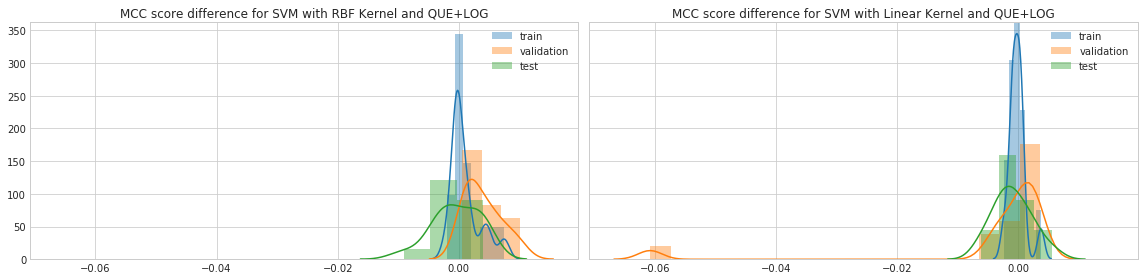

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)
sns.distplot(df_best_rbf[['diff_train_matthews']], ax=ax1, label='train')
sns.distplot(df_best_rbf[['diff_matthews']], ax=ax1, label='validation')
sns.distplot(df_best_rbf[['diff_test_matthews']], ax=ax1, label='test')
sns.distplot(df_best_lin[['diff_train_matthews']], ax=ax2, label='train')
sns.distplot(df_best_lin[['diff_matthews']], ax=ax2, label='validation')
sns.distplot(df_best_lin[['diff_test_matthews']], ax=ax2, label='test')

ax1.set_title('MCC score difference for SVM with RBF Kernel and QUE+LOG')
ax2.set_title('MCC score difference for SVM with Linear Kernel and QUE+LOG')
ax1.legend()
ax2.legend()

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_mcc_diff_per_kernel.png')

Text(0.5,1,'MCC score difference for SVM with Sigmoid Kernel and QUE+LOG')

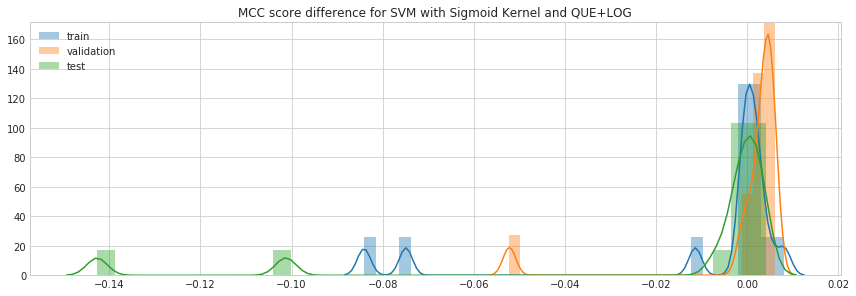

In [24]:
plt.figure(figsize=(12, 4))
sns.distplot(df_best_sig[['diff_train_matthews']], label='train')
sns.distplot(df_best_sig[['diff_matthews']], label='validation')
sns.distplot(df_best_sig[['diff_test_matthews']],  label='test')
plt.legend()
plt.tight_layout()
plt.title('MCC score difference for SVM with Sigmoid Kernel and QUE+LOG')

## McNemar's Test

In [25]:
from sklearn import utils

def get_classes_weights(y_train):
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

def get_svm(x_train, y_label, kernel=None, C=None, gamma=None, coef0=None):
    weights = get_classes_weights(y_label)
    clf = SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, class_weight=weights)
    clf.fit(x_train, y_label)
    return clf

def get_svm_params(df, stock):
    df_stock = df[df['stock'] == int(stock)]
    C = df_stock['C'].values[0]
    gamma = df_stock['gamma'].values[0]
    coef0 = df_stock['coef0'].values[0]
    kernel = df_stock['kernel'].values[0]
    return {
        'C': C,
        'gamma': gamma,
        'coef0': coef0,
        'kernel': kernel
    }

def get_log(x_train, y_label):
    weights = get_classes_weights(y_label)
    clf = LogisticRegression(class_weight=weights)
    clf.fit(x_train, y_label)
    return clf

In [33]:
from statsmodels.stats.contingency_tables import mcnemar
def perform_mcnemar_test(stock, df_best=None):
    data_length = 24000
    df, df_test = lob.load_prepared_data(str(stock), length=data_length)

    clf = get_svm(df[['queue_imbalance']], df['mid_price_indicator'], 
                  **get_svm_params(df_best, stock))
    clf_log = get_log(df[['queue_imbalance']], df['mid_price_indicator'])

    pred = clf.predict(df_test[['queue_imbalance']])

    pred_log = clf_log.predict(df_test[['queue_imbalance']])
    
    df_pred = pd.DataFrame()
    df_pred['svm_pred'] = pred
    df_pred['log_pred'] = pred_log
    df_pred['actual'] = df['mid_price_indicator']
    df_pred['svm_pred_correct'] = (df_pred['svm_pred'] == df_pred['actual']).astype(np.int64)
    df_pred['log_pred_correct'] = (df_pred['log_pred'] == df_pred['actual']).astype(np.int64)
    print(df_pred.head())
    table1 = pd.crosstab(df_pred['svm_pred_correct'], df_pred['log_pred_correct'])
    print(table1)
    res1 = mcnemar(table1, exact=False, correction=True)
    
    return res1

In [34]:
mcnemar_results = []
for stock in df_best['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar = pd.DataFrame(mcnemar_results)
df_mcnemar

   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     1.0                 0                 0
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     0.0                 1                 1
4       0.0       0.0     0.0                 1                 1
log_pred_correct     0     1
svm_pred_correct            
0                 2311    20
1                   64  2405
   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     0.0                 1                 1
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     1.0                 0                 0
4       1.0       1.0     0.0                 0                 0
log_pred_correct     0     1
svm_pred_correct            
0                 2082    14
1    

,p1,stat1,stock
0,2.709646e-06,22.011905,9761
1,1.988831e-12,49.494949,4851
2,1.224306e-05,19.125000,12255
3,2.482623e-36,158.438119,2748
4,1.590485e-15,63.516260,10470
5,1.277224e-07,27.900415,4320
6,2.560113e-02,4.982759,4799
7,6.428348e-01,0.215054,11869
8,7.712534e-03,7.099038,4549
9,1.220622e-11,45.937888,3459


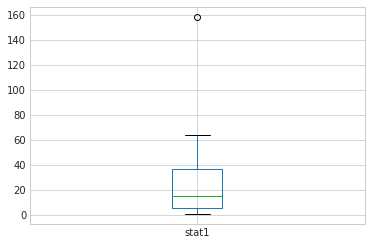

In [35]:
df_mcnemar[['stat1']].boxplot()

In [36]:
df_mcnemar[['p1']].describe()

,p1
count,1.500000e+01
mean,7.862199e-02
std,1.803540e-01
min,2.482623e-36
25%,6.386729e-08
50%,1.091358e-04
75%,2.288072e-02
max,6.428348e-01


In [37]:
df_mcnemar[df_mcnemar['p1'] > 0.001]

,p1,stat1,stock
6,0.025601,4.982759,4799
7,0.642835,0.215054,11869
8,0.007713,7.099038,4549
10,0.020160,5.397959,9268
12,0.334627,0.930909,9061
14,0.147558,2.097315,9062


In [71]:
df_mcnemar[df_mcnemar['stat1'] < 3.84]

,p1,stat1,stock
stock,,,
11869,0.642835,0.215054,11869
9061,0.334627,0.930909,9061
9062,0.147558,2.097315,9062


In [38]:
df_mcnemar.index = df_mcnemar['stock']

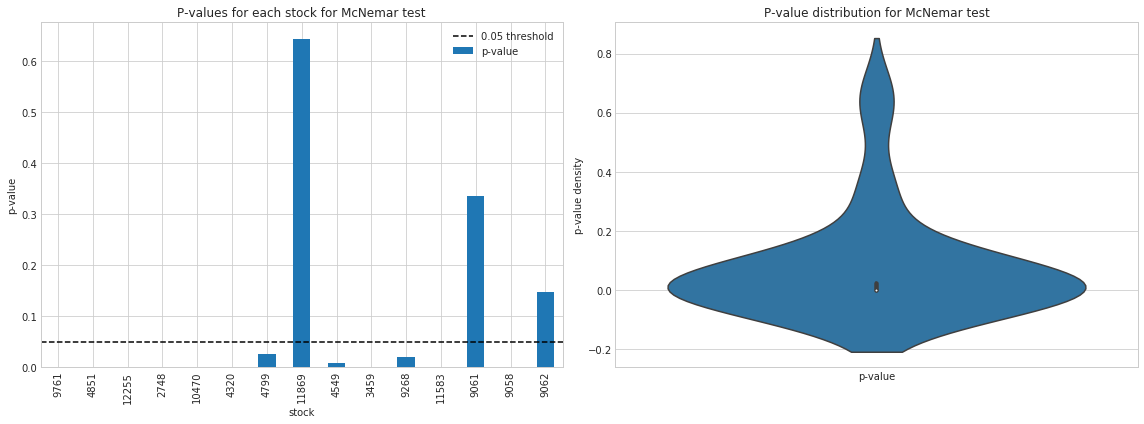

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar[['p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.05, label='0.05', linestyle='--', c='black')
ax1.set_title('P-values for each stock')
ax1.set_ylabel('p-value')
ax1.legend(['0.05 threshold', 'p-value'])
ax1.set_title('P-values for each stock for McNemar test')
sns.violinplot(data=df_mcnemar[['p1']], ax=ax2)
ax2.set_xticklabels(['p-value'])
ax2.set_ylabel('p-value density')
ax2.set_title('P-value distribution for McNemar test')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_p_value.png')

#### Per kernel

In [41]:
mcnemar_results = []
for stock in df_best_lin['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best_lin)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar_lin = pd.DataFrame(mcnemar_results)
df_mcnemar_lin.index = df_mcnemar['stock']
df_mcnemar_lin

   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     1.0                 0                 0
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     0.0                 1                 1
4       0.0       0.0     0.0                 1                 1
log_pred_correct     0     1
svm_pred_correct            
0                 2366    19
1                    9  2406
   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     0.0                 1                 1
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     1.0                 0                 0
4       1.0       1.0     0.0                 0                 0
log_pred_correct     0     1
svm_pred_correct            
0                 2162    28
1    

,p1,stat1,stock
stock,,,
9761,8.897301e-02,2.892857,9761
4851,1.282952e-04,14.666667,4851
12255,2.155627e-02,5.281250,12255
2748,1.248369e-10,41.387755,10470
10470,3.218704e-05,17.284091,4320
4320,2.334220e-02,5.142857,4799
4799,1.156760e-11,46.043165,3459
11869,1.000000e+00,0.000000,11869
4549,2.497468e-02,5.025641,4549


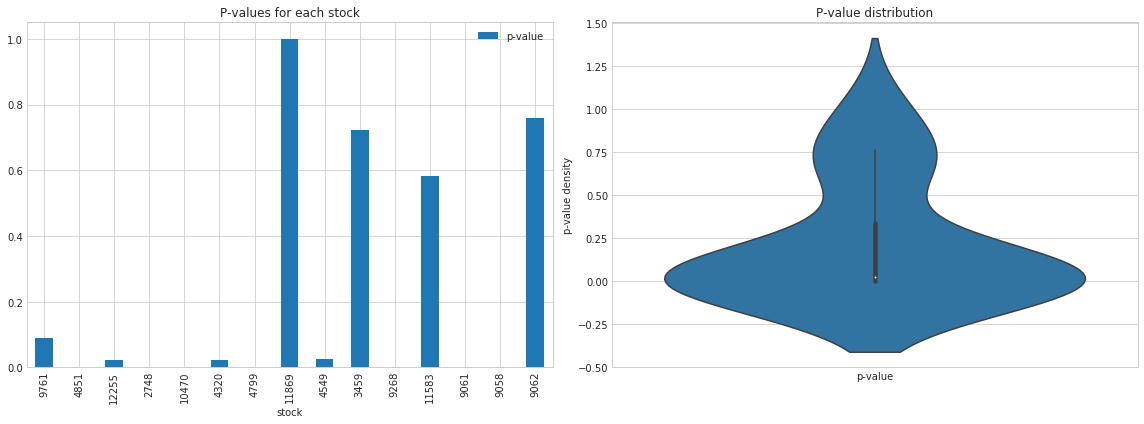

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar_lin[['p1']].plot(kind='bar', ax=ax1)
ax1.legend(['p-value'])
ax1.set_title('P-values for each stock')
sns.violinplot(data=df_mcnemar_lin[['p1']], ax=ax2)
ax2.set_xticklabels(['p-value'])
ax2.set_ylabel('p-value density')
ax2.set_title('P-value distribution')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_p_value_lin.png')

In [43]:
mcnemar_results = []
for stock in df_best_rbf['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best_rbf)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar_rbf = pd.DataFrame(mcnemar_results)
df_mcnemar_rbf.index = df_mcnemar['stock']
df_mcnemar_rbf

   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     1.0                 0                 0
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     0.0                 1                 1
4       0.0       0.0     0.0                 1                 1
log_pred_correct     0     1
svm_pred_correct            
0                 2311    20
1                   64  2405
   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     0.0                 1                 1
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     1.0                 0                 0
4       1.0       1.0     0.0                 0                 0
log_pred_correct     0     1
svm_pred_correct            
0                 2082    14
1    

,p1,stat1,stock
stock,,,
9761,2.709646e-06,22.011905,9761
4851,1.988831e-12,49.494949,4851
12255,2.482623e-36,158.438119,2748
2748,2.511666e-03,9.132075,12255
10470,2.403701e-07,26.677778,10470
4320,1.277224e-07,27.900415,4320
4799,6.428348e-01,0.215054,11869
11869,4.550026e-02,4.000000,4799
4549,2.811981e-01,1.161290,4549


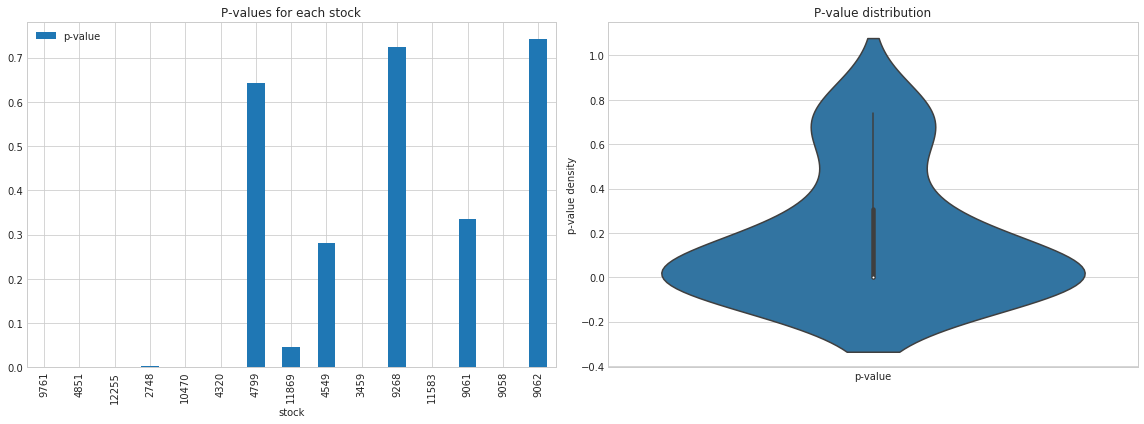

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar_rbf[['p1']].plot(kind='bar', ax=ax1)
ax1.legend(['p-value'])
ax1.set_title('P-values for each stock')
sns.violinplot(data=df_mcnemar_rbf[['p1']], ax=ax2)
ax2.set_xticklabels(['p-value'])
ax2.set_ylabel('p-value density')
ax2.set_title('P-value distribution')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_p_value_rbf.png')

In [45]:
mcnemar_results = []
for stock in df_best_sig['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best_sig)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar_sig = pd.DataFrame(mcnemar_results)
df_mcnemar_sig.index = df_mcnemar['stock']


   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     0.0                 1                 1
1       0.0       0.0     0.0                 1                 1
2       1.0       0.0     0.0                 0                 1
3       1.0       0.0     1.0                 1                 0
4       1.0       1.0     0.0                 0                 0
log_pred_correct     0     1
svm_pred_correct            
0                 2083   405
1                   84  2228
   svm_pred  log_pred  actual  svm_pred_correct  log_pred_correct
0       0.0       0.0     0.0                 1                 1
1       0.0       0.0     0.0                 1                 1
2       0.0       0.0     0.0                 1                 1
3       0.0       0.0     0.0                 1                 1
4       0.0       0.0     0.0                 1                 1
log_pred_correct     0     1
svm_pred_correct            
0                 2297    94
1    

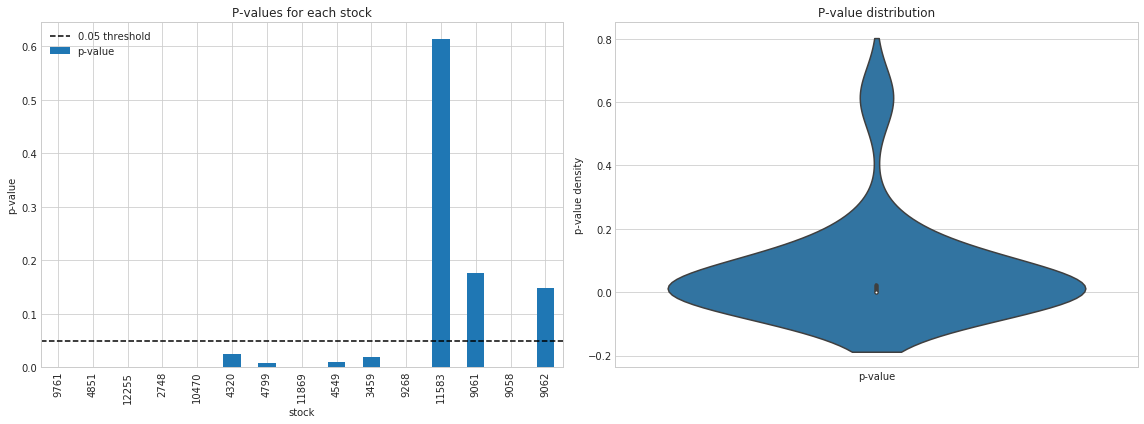

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar_sig[['p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.05, label='0.05', linestyle='--', c='black')
ax1.set_title('P-values for each stock')
ax1.set_ylabel('p-value')
ax1.legend(['0.05 threshold', 'p-value'])
sns.violinplot(data=df_mcnemar_sig[['p1']], ax=ax2)
ax2.set_xticklabels(['p-value'])
ax2.set_ylabel('p-value density')
ax2.set_title('P-value distribution')

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_p_value_sig.png')

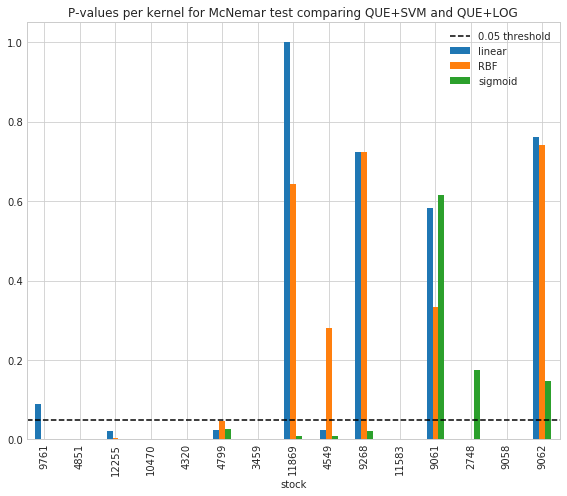

In [67]:
df_p = pd.merge(df_mcnemar_lin, df_mcnemar_rbf, on='stock', suffixes=['_lin', '_rbf'])
df_p = pd.merge(df_p, df_mcnemar_sig, on='stock', suffixes=['', '_sig'])
df_p.index = df_p['stock']

df_p[['p1_lin', 'p1_rbf', 'p1']].plot(kind='bar', figsize=(8, 7))

plt.axhline(y=0.05, label='0.05', linestyle='--', c='black')
plt.legend(['0.05 threshold', 'linear', 'RBF', 'sigmoid'])
plt.title('P-values per kernel for McNemar test comparing QUE+SVM and QUE+LOG')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_mcnemar_per_kernel.png')

In [48]:
df_p[['p1_lin', 'p1_rbf', 'p1']].sort_values(by='p1', ascending=False)

,p1_lin,p1_rbf,p1
stock,,,
9061,5.827020e-01,3.346268e-01,6.142947e-01
2748,6.906029e-08,2.482623e-36,1.757812e-01
9062,7.603683e-01,7.423084e-01,1.475580e-01
4799,2.334220e-02,4.550026e-02,2.560113e-02
9268,7.236736e-01,7.236736e-01,2.016031e-02
11869,1.000000e+00,6.428348e-01,9.374768e-03
4549,2.497468e-02,2.811981e-01,7.712534e-03
9058,1.248831e-03,2.285337e-06,7.120116e-04
4320,3.218704e-05,1.277224e-07,1.071079e-04


### Regular comparision of scores

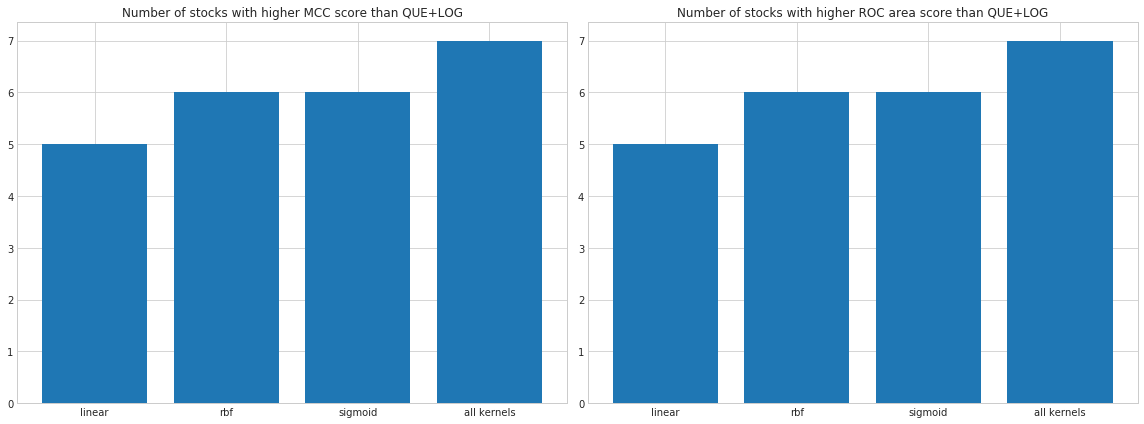

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lin = len(df_best_lin[df_best_lin['test_matthews'] > df_best_lin['test_matthews_log']])
rbf = len(df_best_rbf[df_best_rbf['test_matthews'] > df_best_rbf['test_matthews_log']])
sig = len(df_best_sig[df_best_sig['test_matthews'] > df_best_sig['test_matthews_log']])
b = len(df_best[df_best['test_matthews'] > df_best['test_matthews_log']])
ax1.bar(['linear', 'rbf', 'sigmoid', 'all kernels'], [lin, rbf, sig, b])
ax1.set_title('Number of stocks with higher MCC score than QUE+LOG')

lin = len(df_best_lin[df_best_lin['test_roc_auc'] > df_best_lin['test_roc_auc_log']])
rbf = len(df_best_rbf[df_best_rbf['test_roc_auc'] > df_best_rbf['test_roc_auc_log']])
sig = len(df_best_sig[df_best_sig['test_roc_auc'] > df_best_sig['test_roc_auc_log']])
b = len(df_best[df_best['test_roc_auc'] > df_best['test_roc_auc_log']])
ax2.bar(['linear', 'rbf', 'sigmoid', 'all kernels'], [lin, rbf, sig, b])
ax2.set_title('Number of stocks with higher ROC area score than QUE+LOG')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_vs_log_bar.png')